### **Modules and General Settings**

---



In [216]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

### **Exploring Data**

---



In [217]:
# Load and read the data

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cancerPrediction.csv")

In [218]:
# Initial look at the data

df.head()

,id,Diagnosis,Radius_mean,Texture_mean,Perimeter_mean,Area_mean,Smoothness_mean,Compactness_mean,Concavity_mean,Concave points_mean,Symmetry_mean,Fractal_dimension_mean,Radius_se,Texture_se,Perimeter_se,Area_se,Smoothness_se,Compactness_se,Concavity_se,Concave points_se,Symmetry_se,Fractal_dimension_se,Radius_worst,Texture_worst,Perimeter_worst,Area_worst,Smoothness_worst,Compactness_worst,Concavity_worst,Concave points_worst,Symmetry_worst,Fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [219]:
# Shape of data

print(f"Dataset has {df.shape[0]} rows, and {df.shape[1]} columns.")

# Note: this data has high dimensionality.

Dataset has 569 rows, and 32 columns.


In [220]:
# As a first step, let's standardize column names.

def standardize_column_names(df):

    """
    Standardizes column names of a pandas dataframe.
    
    Args:
        df (pandas.DataFrame): The dataframe to standardize its column names.

    Returns:
        None.
    """

    df.columns = df.columns.str.strip()  # Remove leading and trailing spaces
    df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
    df.columns = df.columns.str.replace('[^\w\s]', '_', regex=True)  # Remove special characters
    df.columns = df.columns.str.lower()  # Lowercase all characters

    print("Column names have been standardized!")

# Standardize
standardize_column_names(df)

Column names have been standardized!


In [221]:
# Some of the columns are unnecessary. Let's drop them.

def drop_columns(column_list, df):
  
    """
    Drops columns from a pandas dataframe that match the names in a given list.
    
    Args:
        column_list (list of str): A list of column names to drop from the dataframe.
        df (pandas.DataFrame): The dataframe from which to drop columns.
        
    Returns:
        None.
    """

    not_found = [col for col in column_list if col not in df.columns]
    if not_found:
        print(f"The following columns were not found in the dataframe:\n{not_found}")

    found = [col for col in df.columns if col in column_list]
    if found:
        df = df.drop(columns=found, inplace=True)
        print(f"The following columns have been dropped:\n{found}")

# Columns to drop
column_list = ["id"]

# Drop
drop_columns(column_list, df)

The following columns have been dropped:
['id']


In [222]:
# Let's identify categorical and numerical columns.

def categorize_columns(df):

    """
    This function takes a pandas DataFrame as input and returns a DataFrame categorized by data type.

    Args:
        df (pd.DataFrame): The pandas DataFrame to categorize.

    Returns:
        pd.DataFrame: A new DataFrame with three columns: 'categoricals', 'numericals', and 'datetimes'
    """
    
    # Categorize columns
    cat_cols = list(df.select_dtypes(include=['category', 'object']).columns)
    num_cols = list(df.select_dtypes(include=['float64', 'int64']).columns)
    datetime_cols = list(df.select_dtypes(include=['datetime']).columns)

    # Create empty cells
    max_len = max(len(cat_cols), len(num_cols), len(datetime_cols))
    cat_cols += [''] * (max_len - len(cat_cols))
    num_cols += [''] * (max_len - len(num_cols))
    datetime_cols += [''] * (max_len - len(datetime_cols))

    # Create new dataframe
    df_categories = pd.DataFrame(
        {'numericals': num_cols,
         'categoricals': cat_cols,
         'datetimes': datetime_cols}
         )

    # Center the text and column names
    centered_text = {'text-align': 'center'}
    centered_header = {'selector': 'th', 'props': [('text-align', 'center')]}
    df_categories = df_categories.style.set_properties(**centered_text).set_table_styles([centered_header])

    return df_categories

# Categorize columns
categorize_columns(df)

,numericals,categoricals,datetimes
0,radius_mean,diagnosis,
1,texture_mean,,
2,perimeter_mean,,
3,area_mean,,
4,smoothness_mean,,
5,compactness_mean,,
6,concavity_mean,,
7,concave_points_mean,,
8,symmetry_mean,,
9,fractal_dimension_mean,,


In [223]:
# Now, we can check for duplicated rows.

def handle_duplicates(df):

    '''
    Finds duplicated rows in a Pandas DataFrame, displays them to the user,
    and optionally drops them.

    Args:
        df (pd.DataFrame): The pandas DataFrame to drop from.

    Returns:
        None.
    '''

    # Find duplicated rows
    duplicates = df[df.duplicated(keep=False)]

    # If no duplicated rows, print a message
    if len(duplicates) == 0:
        print("There are no duplicated rows in the dataset.")
        user_input = ""
    # If there duplicate rows, display them
    else:
        print(f"There are {len(duplicates)} duplicated rows in the dataset:\n")
        print(duplicates)
        # Ask the user if they want to drop the duplicates
        user_input = input("Do you want to drop the duplicated rows? (y/n) ")
    
    if user_input.lower() == "y":
        df.drop_duplicates(inplace=True)
        print(f"{len(duplicates)} rows have been dropped!")
    else:
        print("No rows have been dropped!")

# Check duplicates
handle_duplicates(df)

There are no duplicated rows in the dataset.
No rows have been dropped!


Not imbalanced data:
         the minority class represents 37.26% of the total instances, more than 15%.



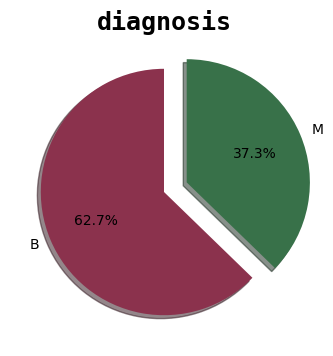

In [224]:
# Check if the data is balanced or not.

def check_imbalance(df, column_name, target_colors=['#8b324d','#387149']):

    """
    Checks if the target variable in a Pandas DataFrame is imbalanced.

    Args:
        target_name (str): The name of the target variable to check.
        df (pandas.DataFrame): The DataFrame containing the target variable.

    Returns:
        None.
    """

    # Count the number of instances of each class
    target_counts = df[column_name].value_counts()

    # Calculate the proportion of the minority class
    minority_proportion = target_counts.min() / target_counts.sum()

    # Check if the minority class represents less than 15% of the total instances
    if minority_proportion < 0.15:
        print(f"Imbalanced data:\n\
         the minority class represents {round(minority_proportion*100, 2)}% of the total instances, less than 15%.\n")
    else:
        print(f"Not imbalanced data:\n\
         the minority class represents {round(minority_proportion*100, 2)}% of the total instances, more than 15%.\n")

    # Plot a pie chart of the target variable
    explode = (0,0.2)

    plt.figure(figsize=(4,4))

    plt.pie(target_counts, explode=explode, labels=target_counts.index,
            autopct='%1.1f%%', shadow=True, startangle=90,
            colors = target_colors)

    plt.title(column_name, fontsize=18,
              weight='bold', fontname = 'monospace')
    
    plt.show()

# Check imbalance
check_imbalance(df, column_name='diagnosis')

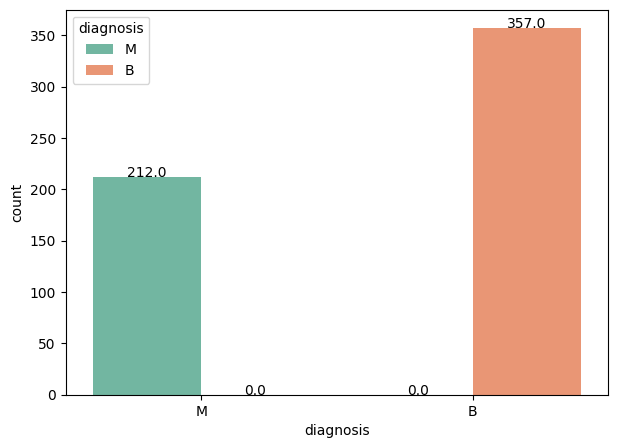

In [225]:
# Let's visualize categorical data.

def plot_counts(df, x, hue):

    '''
    Plots a countplot for categorical data using seaborn's 'countplot'.

    Args:
        df (pandas.DataFrame): The DataFrame to pull columns from.
        x (str): String of the column name for x-axis.
        hue (str): String for hue parameter of countplot.

    Returns:
        None
    '''

    # Plot size
    plt.subplots(figsize=(7, 5))

    # Countplot
    ax = sns.countplot(x=x, hue=hue, palette='Set2', data=df)

    # Write the count numbers on top of bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

# Plot
plot_counts(df, 'diagnosis', 'diagnosis')

In [226]:
# Let's see which columns have missing values first.

def find_missing_values(df):

    """
    Finds categorical and numerical columns with missing values in a Pandas dataframe.

    Args:
        df (pandas.DataFrame): Input dataframe to check for missing values.
        
    Returns:
        None.
    """

    # Get list of categorical and numerical columns
    cat_cols = list(df.select_dtypes(include=['object', 'category']).columns)
    num_cols = list(df.select_dtypes(include=['int', 'float']).columns)

    # Check for missing values in categorical columns
    cat_missing = [
        (col, round(df[col].isnull().mean() * 100, 2))
         for col in cat_cols if df[col].isnull().any()
         ]

    # Report missing values
    if cat_missing:
        print(f"There are {len(cat_missing)} categorical column with missing values:")
        for col, percentage in cat_missing:
            print(f"{col} - {percentage}%")
    else:
        print("No missing values found in categorical columns.\n")

    # Check for missing values in numerical columns
    num_missing = [
        (col, round(df[col].isnull().mean() * 100, 2))
         for col in num_cols if df[col].isnull().any()
         ]

    # Report missing values     
    if num_missing:
        print(f"There are {len(num_missing)} numerical column with missing values:")
        for col, percentage in num_missing:
            print(f"{col} - {df[col].isnull().sum()} rows missing - {percentage}%")
    else:
        print("No missing values found in numerical columns")

# Find missing values
find_missing_values(df)

No missing values found in categorical columns.

No missing values found in numerical columns


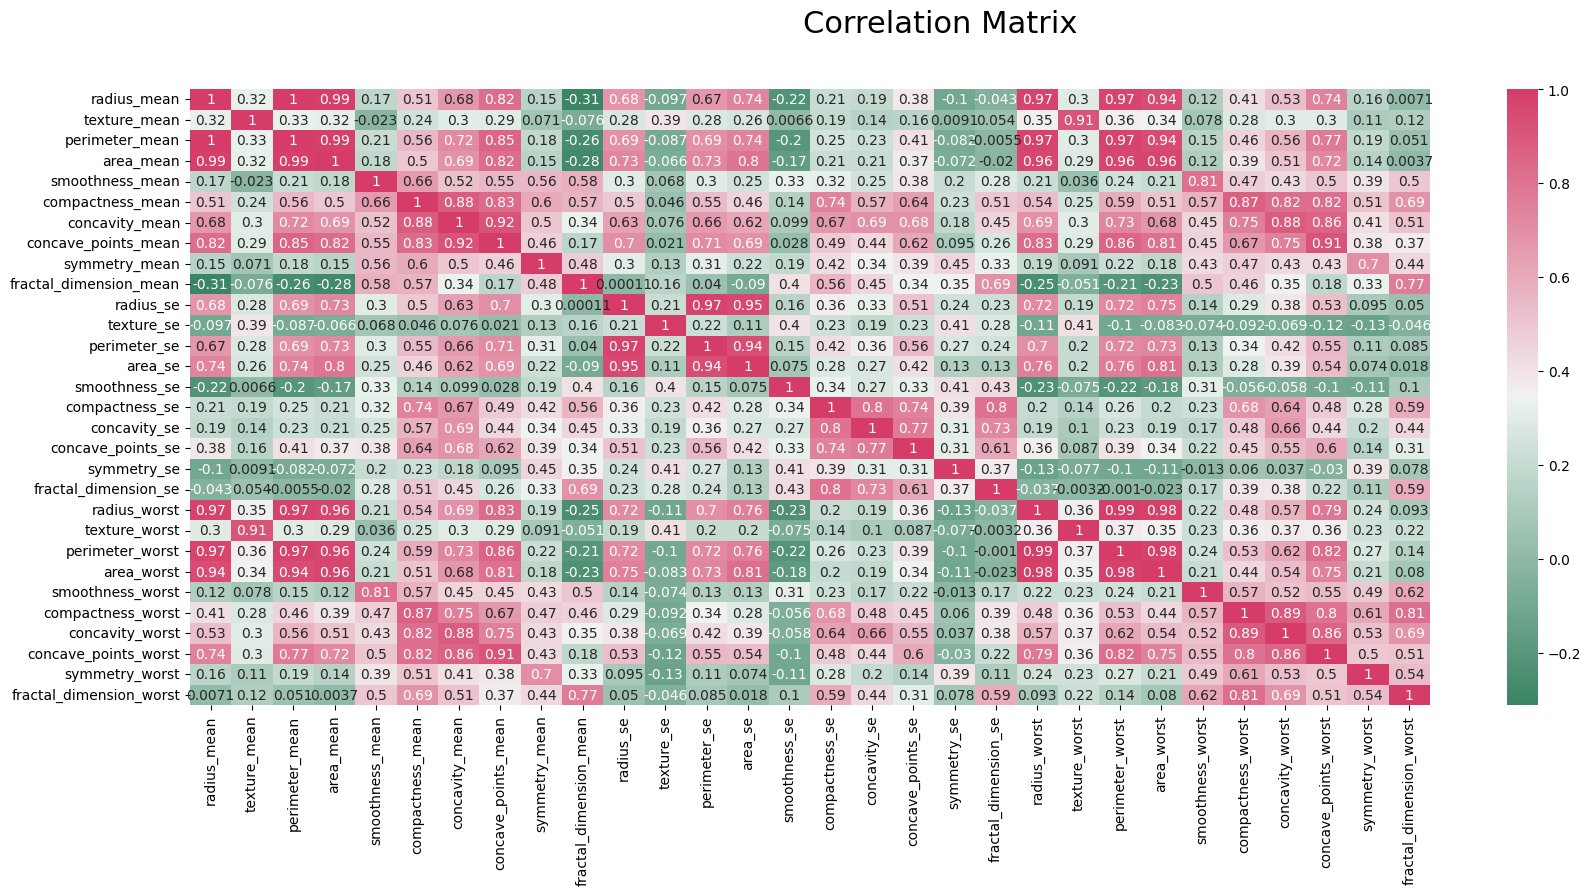

In [227]:
# Correlation Analysis

def plot_heatmap(df):
  
    """
    Plots a heatmap of the correlation matrix for the given dataframe.

    Args:
        df (pandas.DataFrame): The dataframe to visualize the correlation matrix of.

    Returns:
        None.
    """

    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(20,8))

    # Set a centered title
    plt.suptitle('Correlation Matrix', fontsize=22)

    # Heatmap
    cmap = sns.diverging_palette(150, 1, as_cmap=True)
    corr_mat = df.corr()
    sns.heatmap(corr_mat, annot=True, cmap=cmap, ax=ax)
    plt.show()

# Plot heatmap
plot_heatmap(df)

### **Preparing data for modeling**

---



In [228]:
# Now, we encode categorical columns.

def encode_cat_cols(df):
    
    """
    Encodes all categorical columns in a Pandas DataFrame using Scikit-learn's LabelEncoder class.

    Args:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        None.
    """

    # Instantiate label encoder
    le = LabelEncoder()

    # Find categorical columns
    cat_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()

    # Encode each categorical column
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])

    print("Categorical columns have been encoded.")

# Encode categorical columns
encode_cat_cols(df)

Categorical columns have been encoded.


In [229]:
# At this stage we can split the data.

# Create features and target
features = df.drop('diagnosis', axis=1)
target = df['diagnosis']

# Split the data
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.1,
                                                    random_state=42)

print("Shape of training set:", x_train.shape)
print("Shape of test set:", x_test.shape)

Shape of training set: (512, 30)
Shape of test set: (57, 30)


In [230]:
# Next, we will scale the data with sklearn's StandardScaler class.

# Instantiate scaler
ss = StandardScaler()

# Scale features
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)

In [231]:
# Since we will perform Deep Learning, we transform our sets to PyTorch tensors.

# Transform features
x_train = torch.tensor(x_train).float()
x_test = torch.tensor(x_test).float()

# Transform target to numpy arrays first then to tensors
y_test = y_test.values.astype(np.float32)
y_test = torch.tensor(y_test).float()

y_train = y_train.values.astype(np.float32)
y_train = torch.tensor(y_train).float()

### **Modeling**

---



In [232]:
# First we create our deep learning model. 

class ANN(torch.nn.Module):
    
    def __init__(self):
        super(ANN, self).__init__()

        self.l1 = torch.nn.Linear(30, 16)
        self.l2 = torch.nn.Linear(16, 4)
        self.l3 = torch.nn.Linear(4, 1)
        
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        out1 = self.sigmoid(self.l1(x)) 
        out2 = self.sigmoid(self.l2(out1))
        y_prediction = self.sigmoid(self.l3(out2)).squeeze()
        return y_prediction

# Instantiate the model object    
model = ANN()

In [233]:
# Next we define our loss function and optimizer.

# Loss function
loss_bce = torch.nn.BCELoss(reduction='sum')
# When reduction is set to "sum", the loss function returns the sum of the
# element-wise losses across all the samples in the batch.

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [234]:
# Now we can train our system.

total_loss = []
test_loss = []

for epoch in range(5001):
    y_train_prediction = model(x_train)
    loss = loss_bce(y_train_prediction, y_train)

    if epoch%50 == 0:
        print(f"Epoch {epoch}, loss is {loss.item()}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss.append(loss.item())

    with torch.no_grad():
        y_test_predictions = model(x_test)
        loss = loss_bce(y_test_predictions.squeeze(), y_test)
        test_loss.append(loss.item())

Epoch 0, loss is 351.5260009765625
Epoch 50, loss is 333.0421447753906
Epoch 100, loss is 313.81085205078125
Epoch 150, loss is 289.27581787109375
Epoch 200, loss is 257.4879455566406
Epoch 250, loss is 225.72434997558594
Epoch 300, loss is 199.11611938476562
Epoch 350, loss is 177.65328979492188
Epoch 400, loss is 160.18190002441406
Epoch 450, loss is 145.70932006835938
Epoch 500, loss is 133.51821899414062
Epoch 550, loss is 123.1014633178711
Epoch 600, loss is 114.09233093261719
Epoch 650, loss is 106.21737670898438
Epoch 700, loss is 99.27027893066406
Epoch 750, loss is 93.09538269042969
Epoch 800, loss is 87.57369995117188
Epoch 850, loss is 82.61157989501953
Epoch 900, loss is 78.13292694091797
Epoch 950, loss is 74.07278442382812
Epoch 1000, loss is 70.37728881835938
Epoch 1050, loss is 67.00825500488281
Epoch 1100, loss is 63.930484771728516
Epoch 1150, loss is 61.111812591552734
Epoch 1200, loss is 58.52406311035156
Epoch 1250, loss is 56.14244842529297
Epoch 1300, loss is 53.

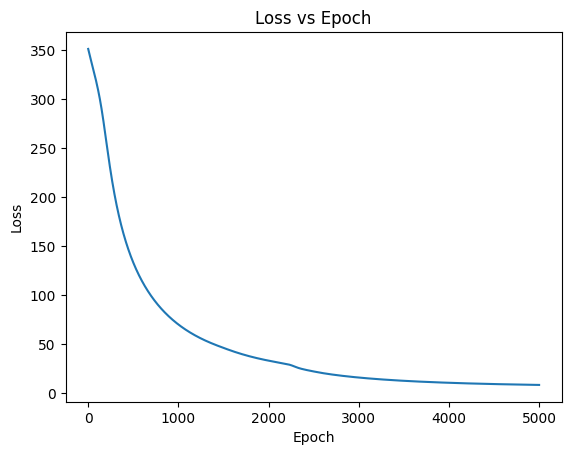

In [235]:
# Total loss graph

plt.plot(total_loss)
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()